# USD AAI 500 final project - Group 3
Group members

- Victoria Dorn
- Victor Hugo Germano

In [1]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import math

sns.set()

# Data Cleaning and Organization

In [2]:
dataset = 'primary'
data = pd.read_csv(f'../dataset/mapped_{dataset}.csv', sep=",")
data = data.drop(columns='uuid')

# Artists affect prices?

Assuming USD only for analysis

- Null hypothesis $H_0$: artists have no impact on prices
- Alt hypothesis $H_A$: artists do have an impact

## Intepretation

The F-statistic of 2.101 suggests that there is a significant amount of variance between the average prices of cards from different artists compared to the variance within each artist's prices.

Since the P-value is significantly less than 0.05, you can reject the null hypothesis (H0), which states that artists have no impact on prices.


### Implications
**Artist Impact:** The results suggest that the artist associated with a card does influence its price, meaning that some artists may produce cards that are valued more highly in the market than others.

**Market Insights:** For collectors and sellers, understanding these differences can inform buying and pricing strategies.


In [3]:
# Hypothesis H0: Artists have no impact on prices

# groups mean prices by artists
artists = data['artist'].unique()

# Create a group of prices for each unique artist to performing a ANOVA test
artist_price_groups = [ data[data['artist'] == artist]['price'].to_numpy()
    for artist in artists if len(data[data['artist'] == artist]['price']) > 1 ]

# Removing Zero Variance artist prices
filtered_prices = [row for row in artist_price_groups if np.var(row) > 0]

In [4]:
# Conduct the one-way ANOVA
# Paper cards, no outliers, Q1_Q3, only in USD
t_stat, p_value = stats.f_oneway(*filtered_prices)

print("Can artist impact prices: \n Data: Paper cards, no outliers, Q1_Q3, only in USD")
print("T-statistic ANOVA: %.4f" % t_stat)
print("P-value: %.6f" % p_value);

if p_value < 0.05:
    print("Reject the null hypothesis. There is a statistically significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no statistically significant difference.")


Can artist impact prices: 
 Data: Paper cards, no outliers, Q1_Q3, only in USD
T-statistic ANOVA: 5.0445
P-value: 0.000000
Reject the null hypothesis. There is a statistically significant difference.


---

# Prediction Exercises

Trying to understand what affects the price the most

In [5]:

# Create linear regression model and use it based on selected feature and target
def prediction(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_test, y_pred, mse, r2


# Price Prediction model - using categorical data

- Mean Squared Error: 1.970043342975583
- R-squared: 0.2172273808523122

Not the best model result

Mean Squared Error: 1.91355490272543
R-squared: 0.35104788760622274


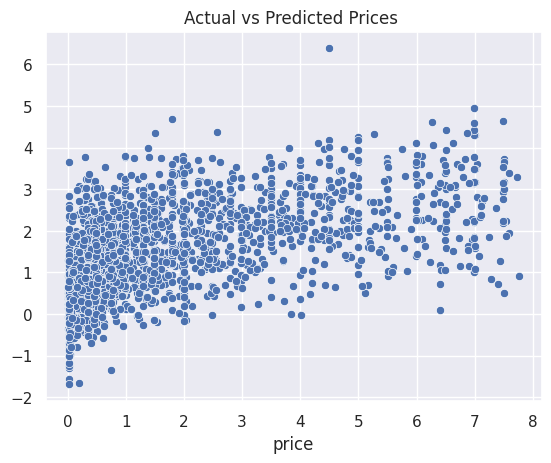

In [6]:
import statsmodels.api as sm
# Price Prediction based on Rank

target = data['price']
features = data.copy()
features = features.drop(columns='price')

# Polinomial Linear Regression
y_test, y_pred, mse, r2 = prediction(features, target)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Ploting results
sns.scatterplot(x=y_test, y=y_pred)
plt.title(f'Actual vs Predicted Prices ')
plt.show()


# OLS data interpretation

## Key Metrics Interpretation

### R-squared and Adjusted R-squared
- **R-squared (0.418)**: Approximately **41.8%** of the variability in card prices can be explained by the independent variables included in the model. 
- **Adjusted R-squared (0.417)**: indicates that the model's explanatory power remains consistent even after accounting for additional variables.

### F-statistic and Prob (F-statistic)
- **F-statistic (550.1)**: Sugests that at least one predictor variable significantly contributes to explaining the variability in price.
- **Prob (F-statistic) (0.00)**: Model is statistically significant, where independent variables collectively have a significant effect on card prices.

## Conclusions

Highest Contributors to price increse

- **Finishes Encoded**: Coefficient: **0.1251** suggests that cards with different finishes (like foil) tend to be priced higher by about $0.13 on average.
- **Price Provider Encoded**: - Coefficient: **0.3187** indicates that different price providers contribute to higher prices on average, which is statistically significant.

The OLS regression results suggest that several factors significantly influence card prices, including rarity, power, artist identity, finish type, EDHREC rank, price provider, and set code.

1) The negative impact of rarity on price may indicate market dynamics where rarer cards are less frequently sold or valued differently.
2) The positive relationship between power and price suggests that more powerful cards are valued higher by collectors and players.
3) Collectors and sellers can leverage these insights to inform pricing strategies based on card attributes.

In [7]:
# Checking statsmodel OLS
model = sm.OLS(target,features) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.498
Model:                            OLS   Adj. R-squared (uncentered):              0.497
Method:                 Least Squares   F-statistic:                              654.9
Date:                Sat, 12 Oct 2024   Prob (F-statistic):                        0.00
Time:                        06:18:59   Log-Likelihood:                         -27745.
No. Observations:               15214   AIC:                                  5.554e+04
Df Residuals:                   15191   BIC:                                  5.571e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
artist              -0.0001   9.52e-05     -1.390      0.164      -0.000    5.43e-05
cardFinish          -0.3984      0.022    -17.710      0.000      -0.443      -0.354
colorIdentity        0.0150      0.006      2.652      0.008       0.004       0.026
colors              -0.0137      0.006     -2.406      0.016      -0.025      -0.003
edhrecRank       -4.789e-05   2.71e-06    -17.658      0.000   -5.32e-05   -4.26e-05
edhrecSaltiness      0.8681      0.043     20.391      0.000       0.785       0.952
gameAvailability     1.3893      0.049     28.612      0.000       1.294       1.485
isReprint           -0.1448      0.027     -5.333      0.000      -0.198      -0.092
layout               0.2547      0.029      8.863      0.000       0.198       0.311
manaCost             0.0003      0.000      1.657      0.098   -4.67e-05       0.001
manaValue            0.0621      0.010      6.258      0.000       0.043       0.082
name             -1.338e-05   3.18e-05     -0.420      0.674   -7.58e-05     4.9e-05
number            8.447e-05   6.24e-05      1.354      0.176   -3.78e-05       0.000
originalType        -0.0010      0.000     -6.922      0.000      -0.001      -0.001
power               -0.0038      0.007     -0.553      0.580      -0.017       0.010
priceProvider       -0.1241      0.017     -7.138      0.000      -0.158      -0.090
providerListing     -0.4133      0.038    -10.768      0.000      -0.489      -0.338
rarity              -0.4203      0.013    -31.138      0.000      -0.447      -0.394
setCode              0.0012      0.000      4.969      0.000       0.001       0.002
supertypes           0.2266      0.055      4.153      0.000       0.120       0.334
toughness           -0.0193      0.009     -2.244      0.025      -0.036      -0.002
type                 0.0006      0.000      3.581      0.000       0.000       0.001
types                0.4023      0.056      7.231      0.000       0.293       0.511
==============================================================================
Omnibus:                     4828.653   Durbin-Watson:                   1.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13067.893
Skew:                           1.723   Prob(JB):                         0.00
Kurtosis:                       5.957   Cond. No.                     3.99e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.99e+04. This might indicate that there are
strong multicollinearity 

# Self organizing maps

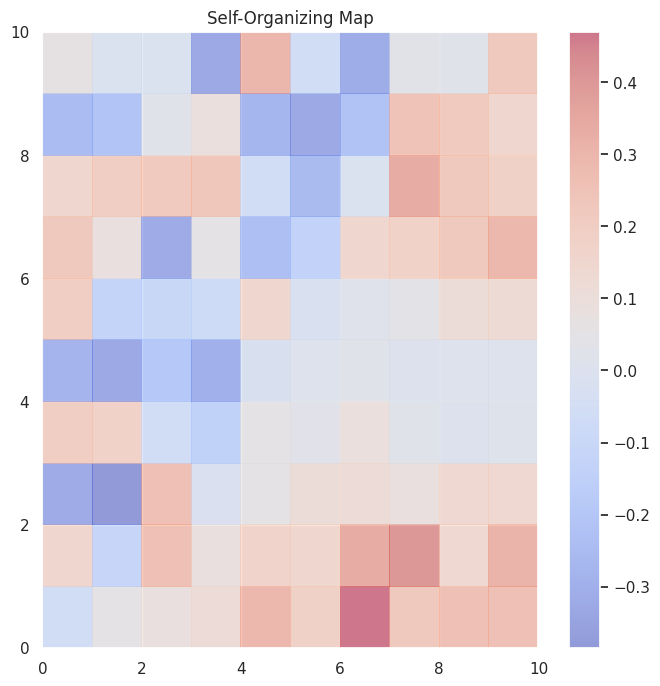

In [8]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image, display
import time

# normalize
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(data)
som_size = 10

som = MiniSom(som_size, som_size, len(data.columns), sigma=1.0, learning_rate=0.5)
som.train(norm_data, 1000)

plt.figure(figsize=(8, 8))
plt.pcolor(som.get_weights()[:, :, 0], cmap='coolwarm', alpha=0.5)
plt.colorbar()
plt.title('Self-Organizing Map')
plt.show()


In [9]:
win_map = som.win_map(norm_data)
cluster_characteristics = {}

# Loop through the win map to calculate mean prices for each cluster
for (x, y), indices in win_map.items():
    for i in indices:
        prices = data.iloc[i]['price'].values

    # Calculate mean price for the cluster
    mean_price = np.mean(prices) if len(prices) > 0 else 0
    median_price = np.median(prices) if len(prices) > 0 else 0
    std_price = np.std(prices) if len(prices) > 0 else 0

    # Store in the dictionary
    cluster_characteristics[(x, y)] = {'mean_price': mean_price, 'median_price': median_price, 'std_price': std_price}

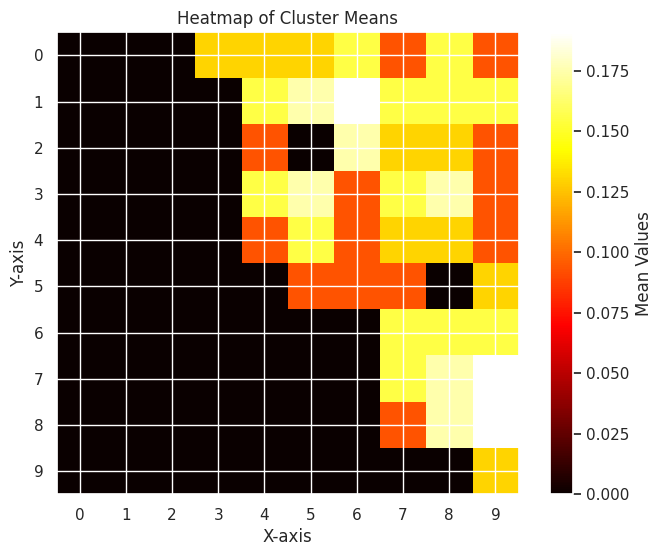

In [10]:
mean_values = np.zeros((10, 10))

# Populate the grid with the means
for (x, y), values in cluster_characteristics.items():
    mean_values[x, y] = values['std_price']

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mean_values, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Values')
plt.title('Heatmap of Cluster Means')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Optionally, add grid lines and labels
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.yticks(ticks=np.arange(10), labels=np.arange(10))
plt.grid(color='white', linestyle='-', linewidth=1)

plt.show()

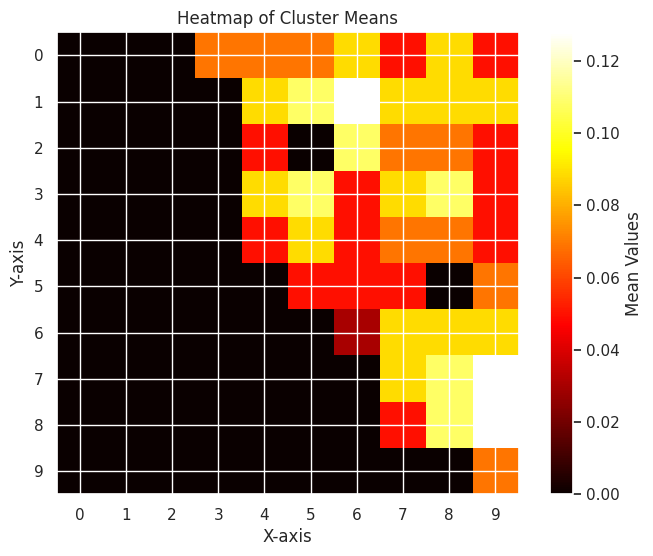

In [11]:
mean_values = np.zeros((10, 10))

# Populate the grid with the means
for (x, y), values in cluster_characteristics.items():
    mean_values[x, y] = values['mean_price']

# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(mean_values, cmap='hot', interpolation='nearest')
plt.colorbar(label='Mean Values')
plt.title('Heatmap of Cluster Means')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Optionally, add grid lines and labels
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.yticks(ticks=np.arange(10), labels=np.arange(10))
plt.grid(color='white', linestyle='-', linewidth=1)

plt.show()

In [12]:
def plt_som(win_map,col):
    
    cluster_characteristics = {}

    # Loop through the win map to calculate mean prices for each cluster
    for (x, y), indices in win_map.items():
        for i in indices:
            values = data.iloc[i][col].values

        # Calculate mean price for the cluster
        mean_col = np.mean(values) if len(values) > 0 else 0
        median_col = np.median(values) if len(values) > 0 else 0
        std_col = np.std(values) if len(values) > 0 else 0

        # Store in the dictionary
        cluster_characteristics[(x, y)] = {f'mean_{col}': mean_col, f'median_{col}': median_col, f'std_{col}': std_col}
        
    mean_values = np.zeros((10, 10))

    for (x, y), values in cluster_characteristics.items():
        mean_values[x, y] = values[f'mean_{col}']

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_values, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Mean Values')
    plt.title(f'{col} Heatmap of Cluster Means')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Optionally, add grid lines and labels
    plt.xticks(ticks=np.arange(10), labels=np.arange(10))
    plt.yticks(ticks=np.arange(10), labels=np.arange(10))
    plt.grid(color='white', linestyle='-', linewidth=1)

    plt.show()

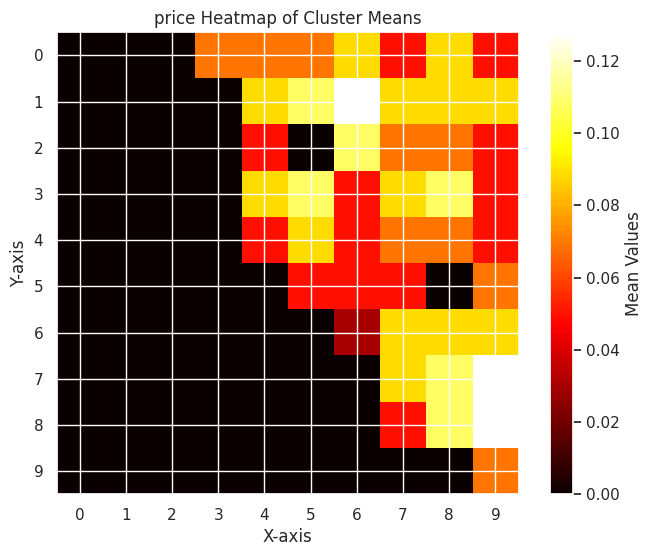

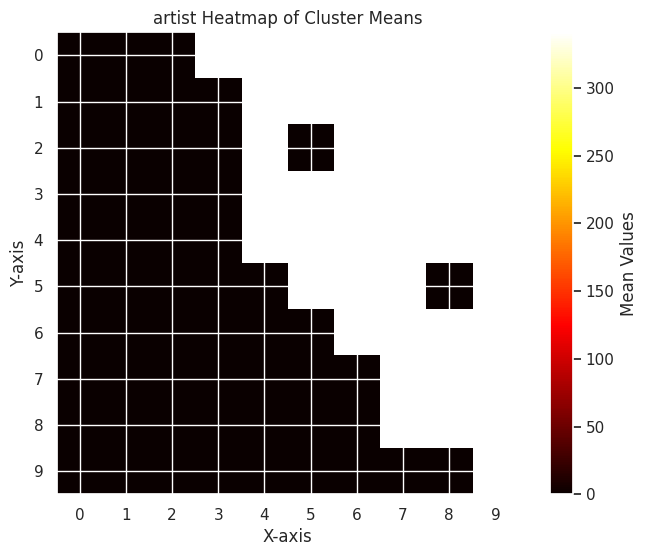

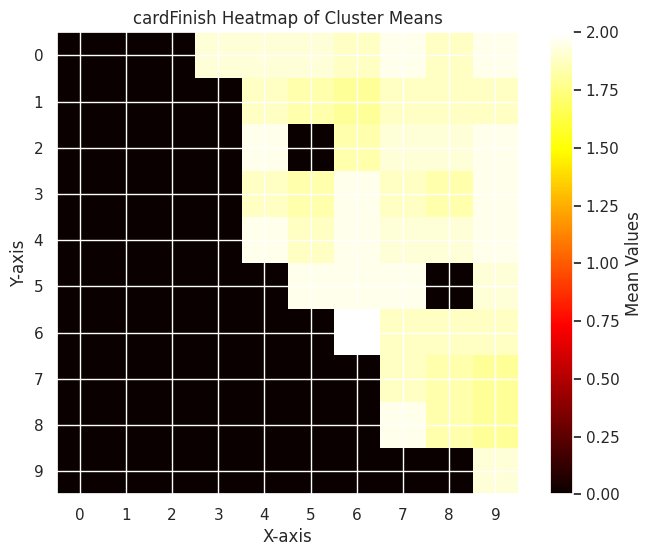

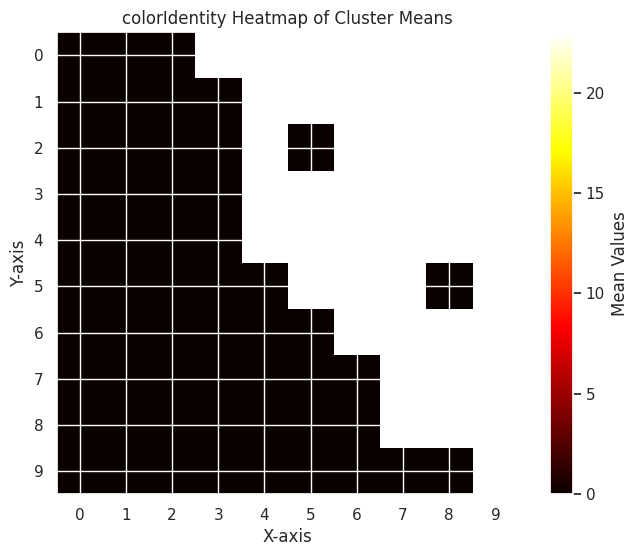

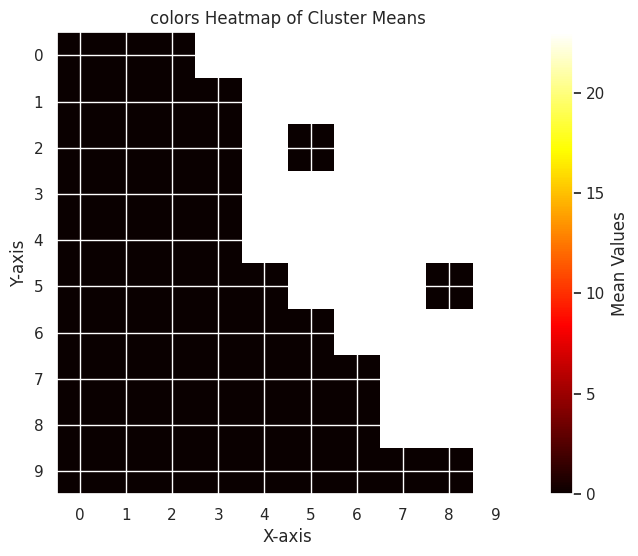

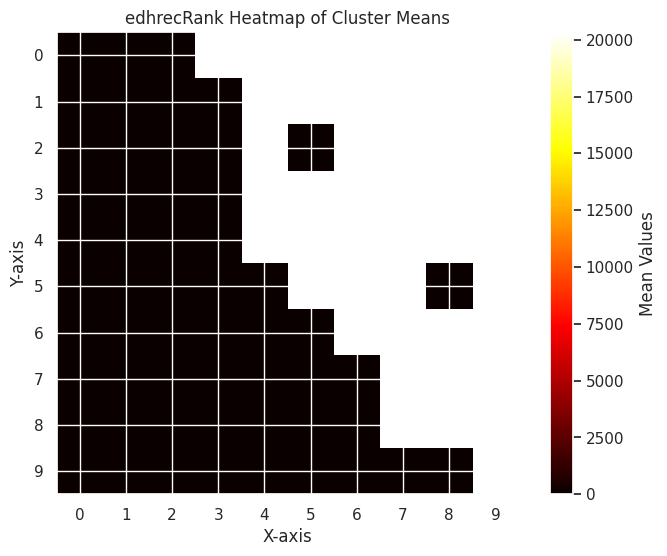

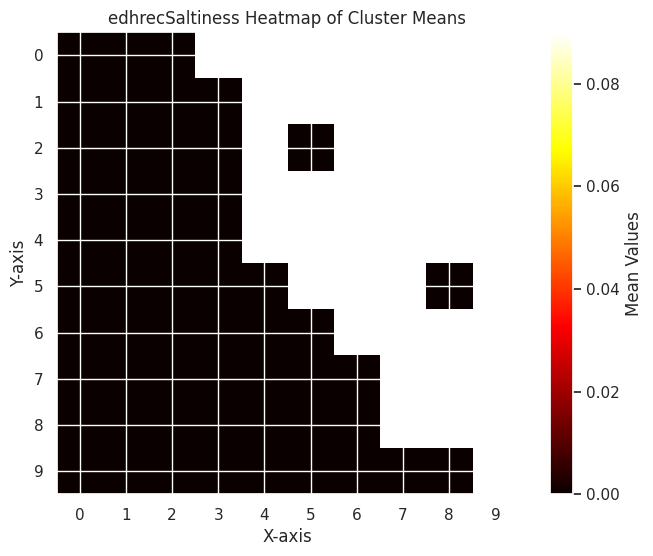

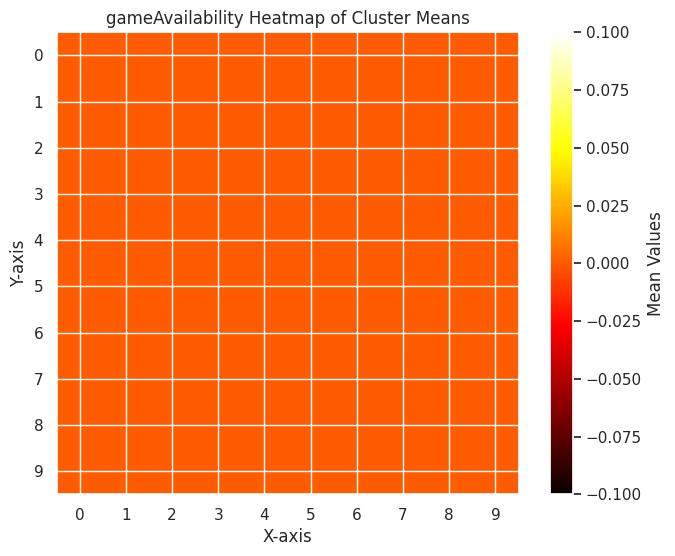

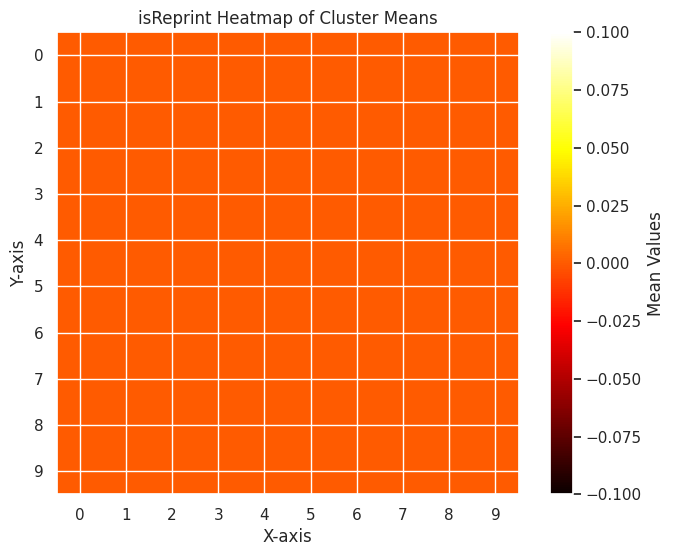

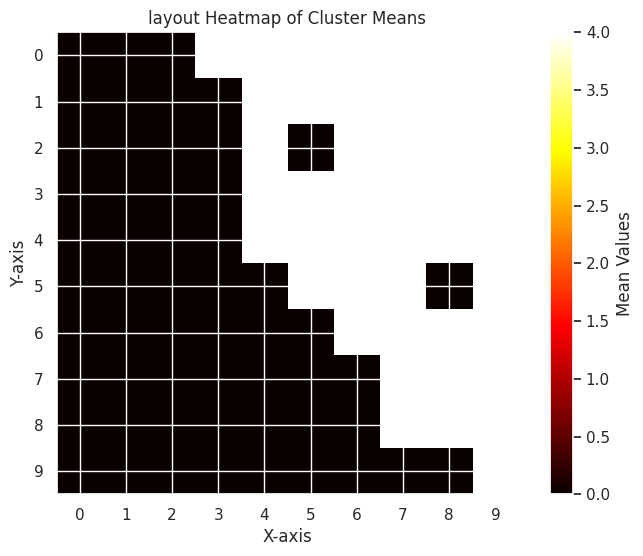

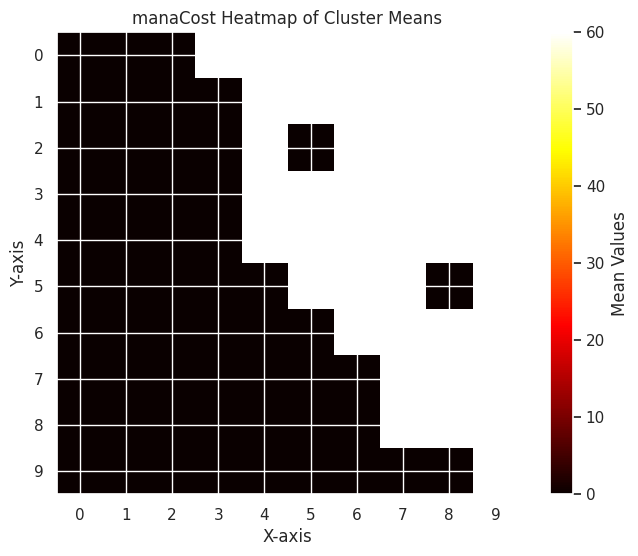

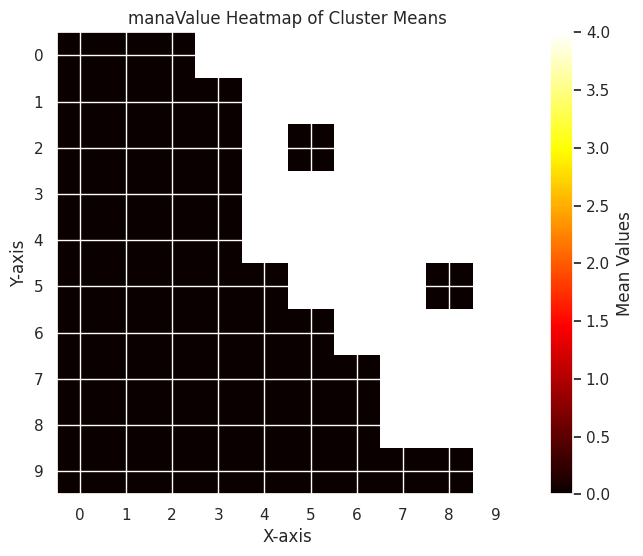

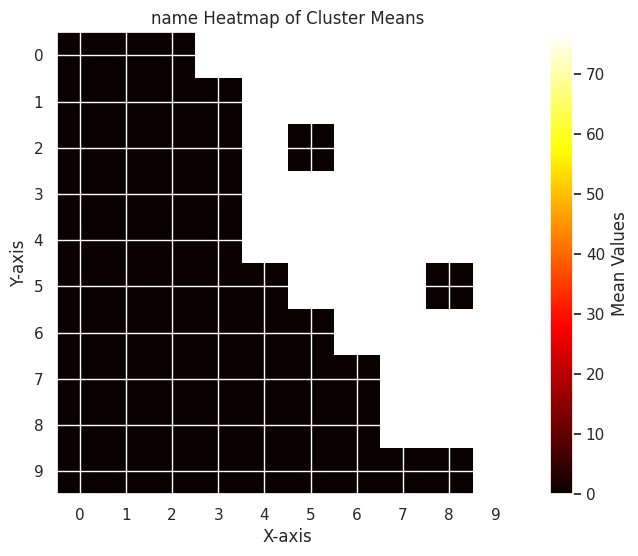

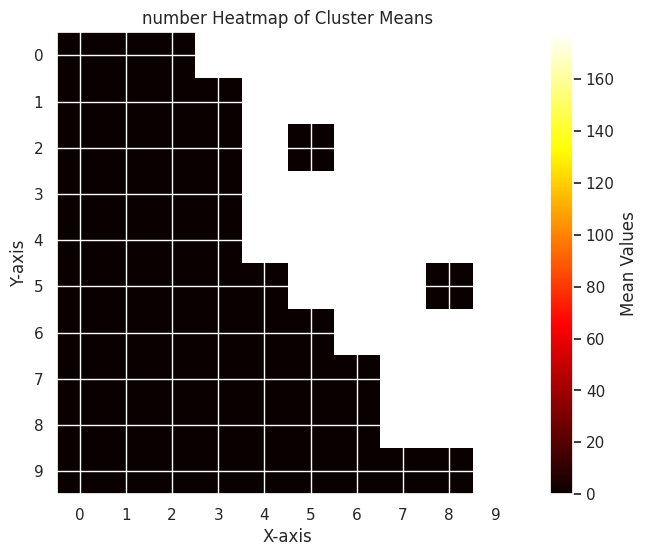

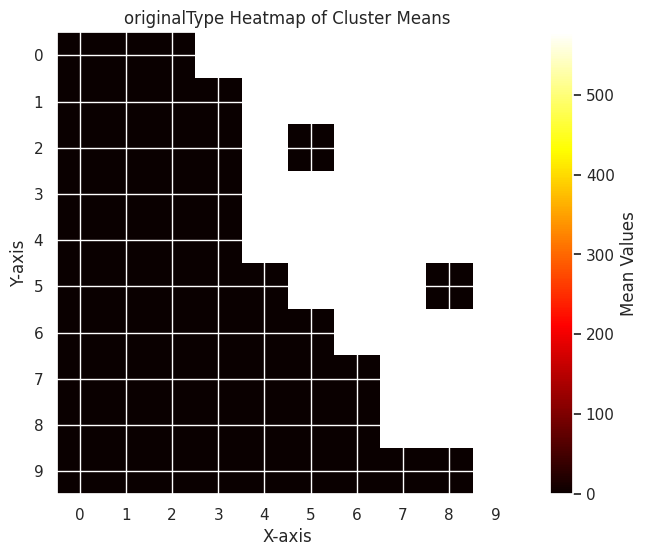

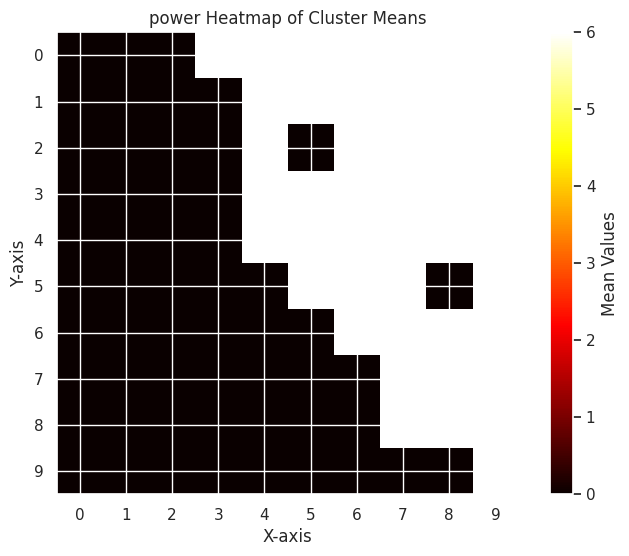

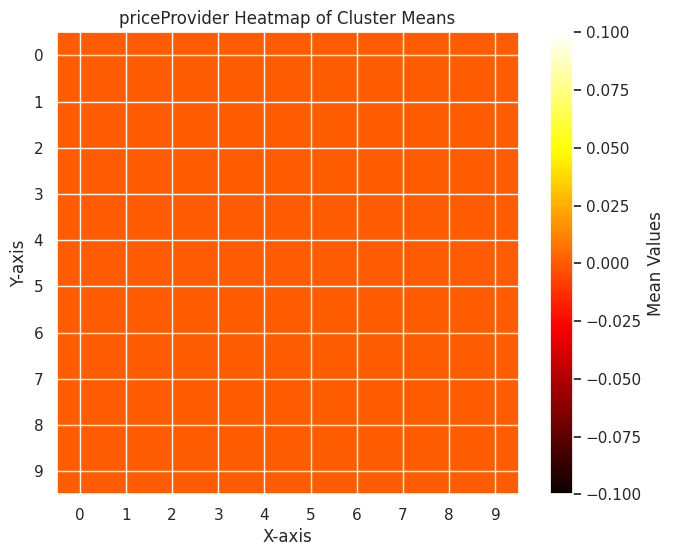

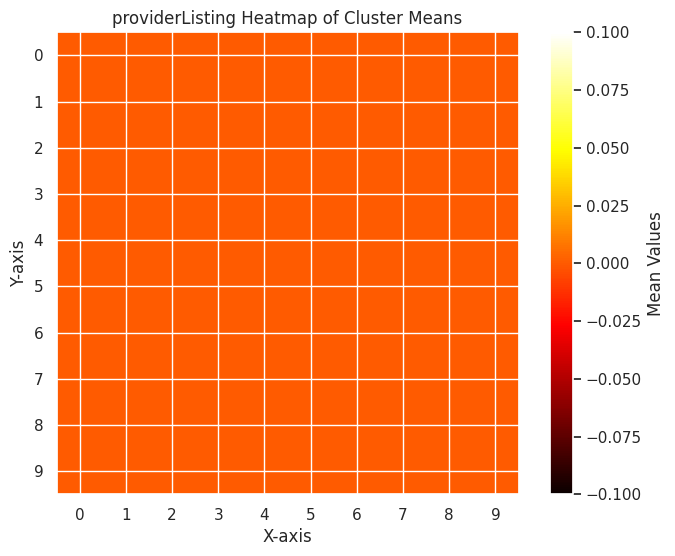

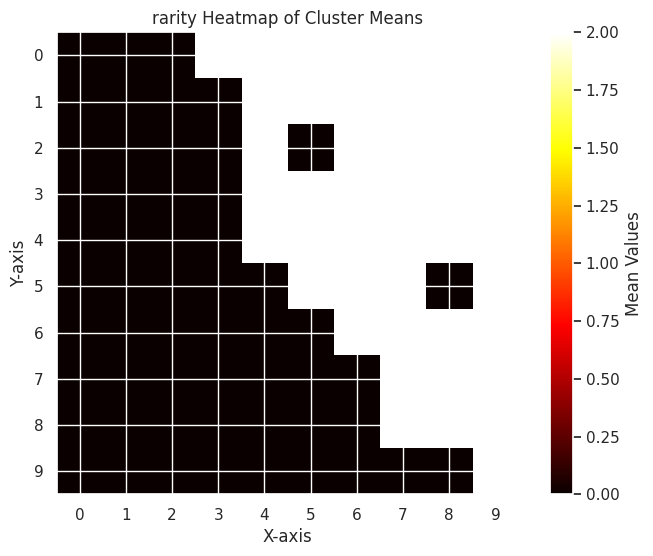

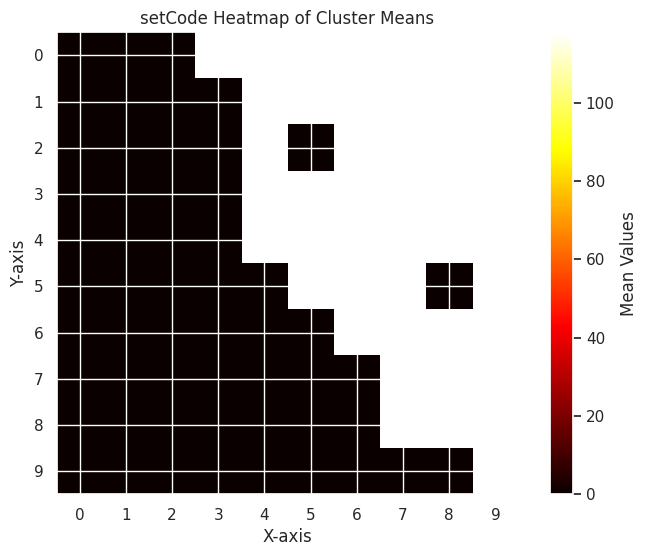

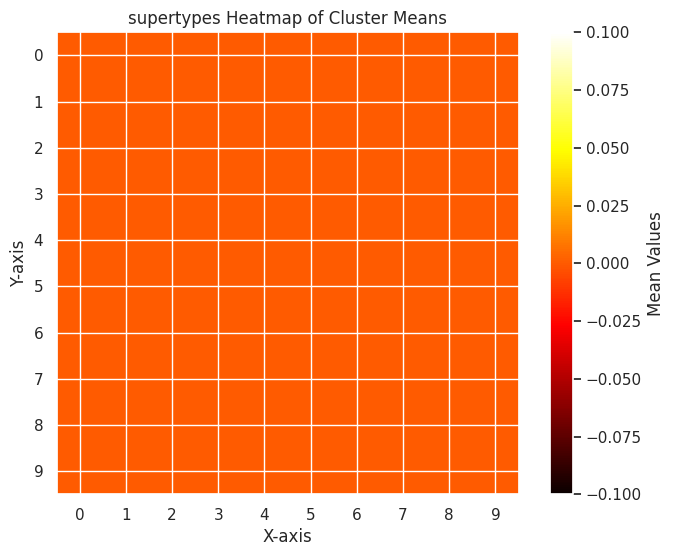

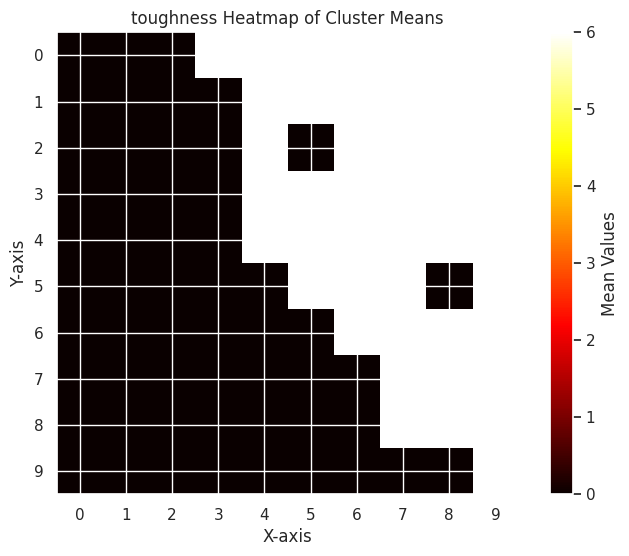

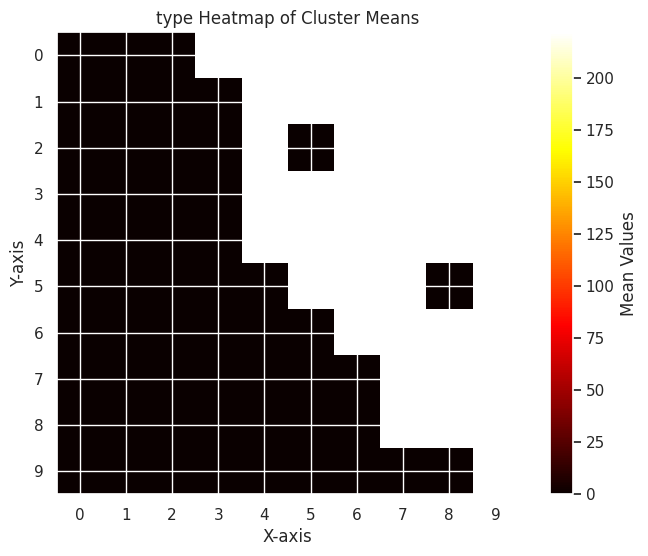

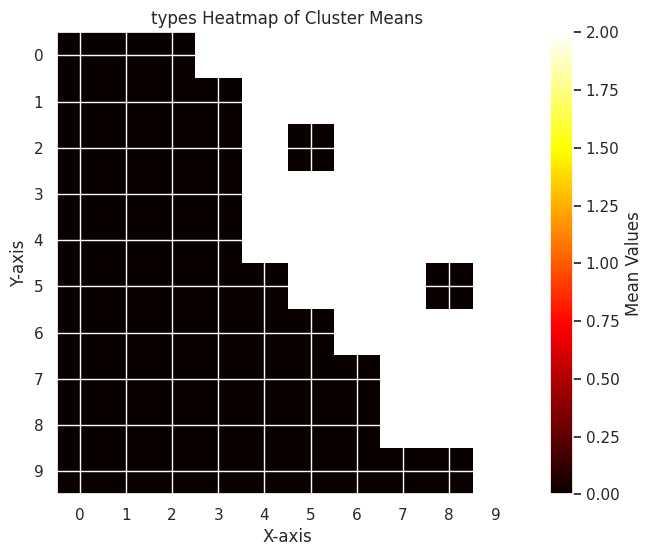

In [13]:
for i in data.columns:
    plt_som(win_map, i)

In [14]:
# Assuming cluster_prices dictionary is already defined
mean_cluster_prices = {}

# Calculate the mean price for each cluster
for cluster, prices in cluster_prices.items():
    if prices:  # Ensure there are prices to calculate the mean
        mean_price = np.mean(prices)
        mean_cluster_prices[cluster] = mean_price

print(mean_cluster_prices)


NameError: name 'cluster_prices' is not defined

In [ ]:
# Assuming 'som' is your trained SOM and 'mean_cluster_prices_df' contains the mean prices
# Get the coordinates of the winning neurons from the SOM
som_coords = som.get_weights()

# Prepare a scatter plot for the SOM neurons
plt.figure(figsize=(10, 10))

# Plot the SOM neurons as a heatmap
plt.imshow(som_coords[:, :, 0], cmap='coolwarm', alpha=0.5)  # Adjust the alpha for visibility

# Overlay mean prices on the clusters
for cluster, mean_price in mean_cluster_prices.items():
    # Use the cluster's coordinates (x, y) from the 'win_map'
    # Find the coordinates of the cluster in the SOM
    if cluster in win_map:
        # Get the mean price coordinates (use the first vector for position)
        cluster_coords = win_map[cluster][0]  # Get the first vector for simplicity
        plt.scatter(cluster_coords[0], cluster_coords[1], s=200, 
                    c='black', edgecolor='white', label=f'Cluster {cluster} Mean Price: {mean_price:.2f}')

# Adding labels and title
plt.title('SOM Clusters with Mean Prices Overlay')
plt.xlabel('SOM X Coordinate')
plt.ylabel('SOM Y Coordinate')
plt.colorbar(label='Price')
plt.grid(True)
plt.show()

In [ ]:
num_clusters = len(data['price'].unique())



       price  artist  cardFinish  colorIdentity  colors  edhrecRank  \
0       0.03     341           2             23      23     20330.0   
1       0.50     341           1             23      23     20330.0   
2       1.31     341           2             23      23     20330.0   
3       0.15     341           2             23      23     20330.0   
4       0.99     341           2             23      23     20330.0   
...      ...     ...         ...            ...     ...         ...   
15209   0.45     274           2             16      16      5527.0   
15210   0.20     274           1             16      16      5527.0   
15211   1.79     274           2             16      16      5527.0   
15212   0.99     274           1             16      16      5527.0   
15213   1.70     274           2             16      16      5527.0   

       edhrecSaltiness  gameAvailability  isReprint  layout  ...  \
0                 0.09                 0          0       4  ...   
1          

IndexError: list index out of range

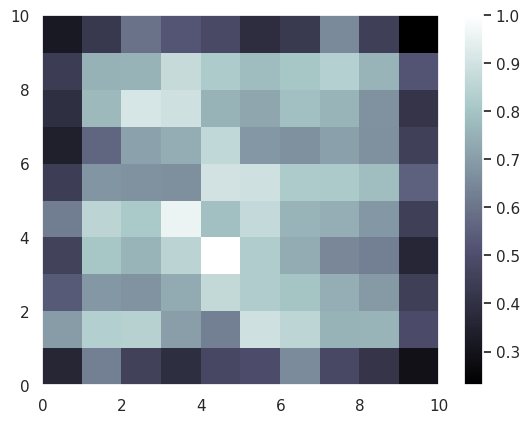

In [19]:
from pylab import bone, pcolor, colorbar, plot, show
y = data.iloc[:, -1].values

bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(to_train):
    i -= 1
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

# whiter they are the far apart
# the darker they are the closer together

Almost no clusterization, and data totally spread out, and overlaps

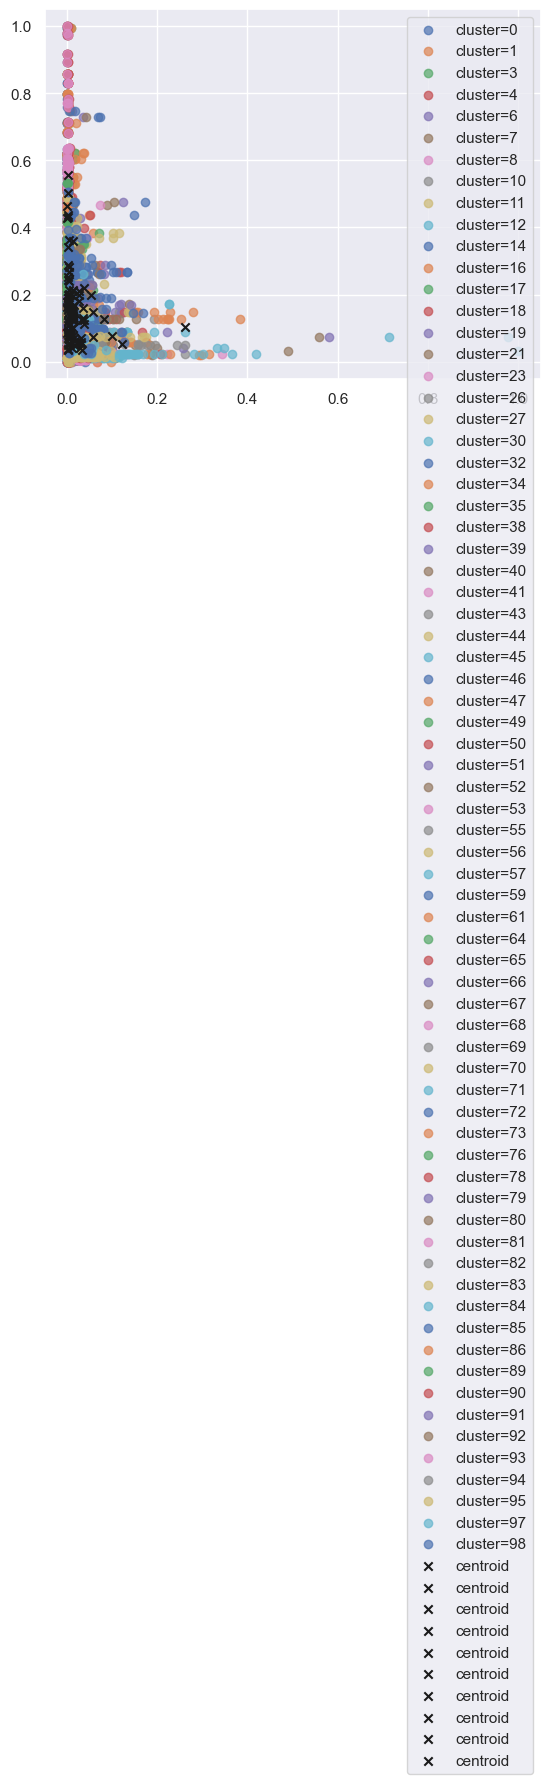

In [51]:

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(to_train[cluster_index == c, 0],
                to_train[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', color='k', label='centroid')
plt.legend();
plt.show()

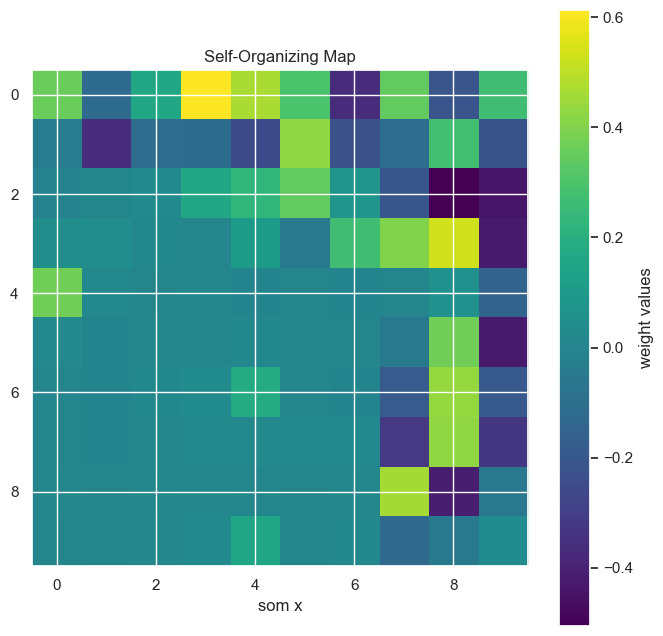

In [28]:

plt.figure(figsize=(8,8))
weights = som.get_weights()
plt.imshow(weights[:,:,0], interpolation='nearest', cmap='viridis')
plt.colorbar(label='weight values')
plt.title("Self-Organizing Map")
plt.xlabel("som x")
plt.show()

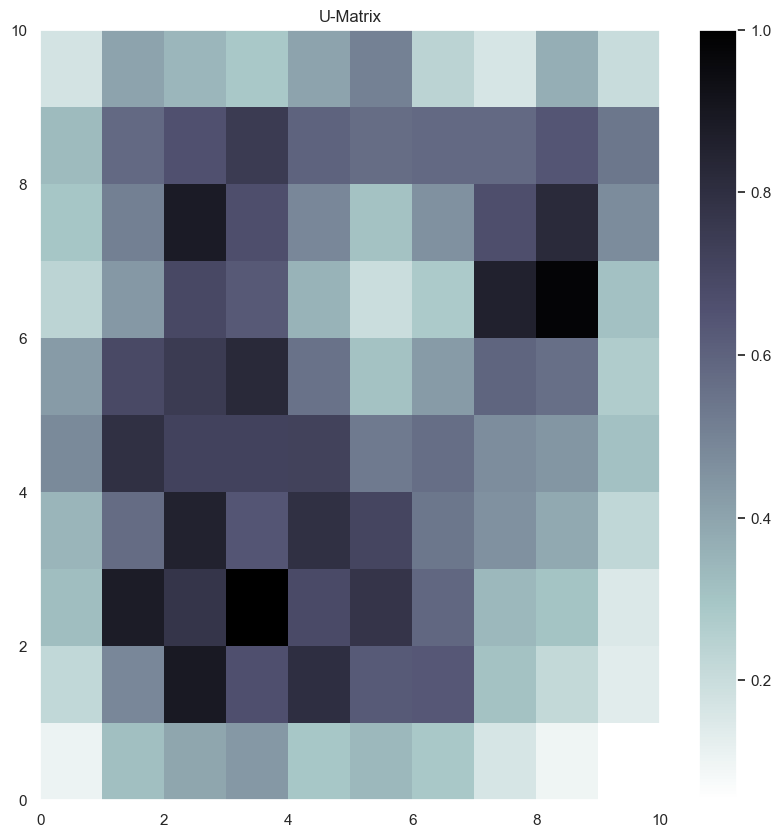

In [52]:
# Plot the distance map (U-matrix)
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map
plt.colorbar()
plt.title('U-Matrix')
plt.show()
